<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/bdb_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#how fast will this kernel crash
O/U 30 mins

In [ ]:
import pyarrow

In [ ]:
pyarrow.__version__

'10.0.1'

## Load in

there's actually some things in the load in that'll help you out if you're doing this stuff:  

Merge `plays.csv` and `games.csv` into one dataframe. That'll help out with play lookups if you're keying in on specific weeks and don't want to load in 18M rows of tracking data.  


In [ ]:
!apt install imagemagick
!pip install shap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

In [ ]:
import os
from IPython.display import HTML, Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

rc('animation', html='html5')

import shap
shap.initjs()

In [ ]:
project_dir = 'drive/My Drive/bdb21'
weeks_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'week' in x]
players_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'players' in x]
games_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'games' in x]
plays_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'plays' in x]
df_players = pd.read_csv(players_fns[0])

# i merge games and plays right here
df_games = pd.read_csv(games_fns[0])
df_plays = pd.read_csv(plays_fns[0])
df_plays = df_plays.merge(df_games)

one_week = pd.read_csv(weeks_fns[0])
one_week.shape

(986022, 19)

In [ ]:
one_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986022 entries, 0 to 986021
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           986022 non-null  object 
 1   x              986022 non-null  float64
 2   y              986022 non-null  float64
 3   s              986022 non-null  float64
 4   a              986022 non-null  float64
 5   dis            986022 non-null  float64
 6   o              919109 non-null  float64
 7   dir            919109 non-null  float64
 8   event          986022 non-null  object 
 9   nflId          919109 non-null  float64
 10  displayName    986022 non-null  object 
 11  jerseyNumber   919109 non-null  float64
 12  position       919109 non-null  object 
 13  frameId        986022 non-null  int64  
 14  team           986022 non-null  object 
 15  gameId         986022 non-null  int64  
 16  playId         986022 non-null  int64  
 17  playDirection  986022 non-nul

# Make animated gifs of plays

thanks to Alison Salerno for these code snippets:  
https://medium.com/@salernoali/making-an-animated-graph-with-matplotlib-seaborn-3f865fa8c16a  

As Louis Tiao suggests, working with HTML5 is a good way to visualize animation in Google Colab. As I've experienced, exporting GIF and video from `jshtml` is actually fairly difficult in comparison to the `html5` process. https://colab.research.google.com/drive/1wnuz6skyo-KQxGiM0UYXwvJA97nWY2_a?usp=sharing

In [ ]:
top_epa_play = df_plays.loc[df_plays['week']==1].sort_values('epa', ascending=False).head(1)
top_epa_play['playDescription'].values[0]

# top_epa_play = df_plays.loc[(df_plays['gameId']==2018123010) & (df_plays['playId']==3365)]
# top_epa_play['playDescription'].values[0]

'(14:50) M.Ryan pass deep left to J.Jones to TB 38 for 37 yards (I.Johnson).'

In [ ]:
week = top_epa_play['week'].values[0]
week_fn = f'drive/My Drive/bdb21/Data/week{week}.csv'
one_week = pd.read_csv(week_fn)
one_play = one_week.merge(top_epa_play.loc[:, ['gameId', 'playId']])
los = one_play.loc[(one_play['frameId']==1) & (one_play['team']=='football'), 'x'].round(0).astype(int).values[0]

When you're making animated GIF in Colab, there are some finnicky things that you'll encounter that are slightly different from your local kernel of iPython Notebook (or JupyterLab). Using the `html5` approach, it seems like you should add all your aesthetics at the ax level or they won't show up. a good example here is the `sns.despine()` cal in this function. That actually doesn't despine anything in the animated GIF. Rather, you'd want to specify `sns.despine(ax=ax)` in order to get the despine aesthetic.  

We avoid having to do `blit=True` in this example by forcing a "background clear" via `ax.cla()`. This seems fairly common in a lot of different examples across the internet, but definitely is a little hacky. The `blit=True` and `init_func=init_func()` method is definitely less hacky but seemingly requires more code (aka an `init_func()` to initialize the plot data and an updating function akin to `animate()` that returns updated data, and not necessarily an entire ax or figure).  

Also, in this example, the save is to the "local" Google Colab folder and not into Google Drive.

In [ ]:
def get_play_by_frame(fid, ax):
  ax.cla()
  one_frame = one_play.loc[one_play['frameId']==fid]
  fig1 = sns.scatterplot(x='x',y='y',data=one_frame, hue='team', ax=ax)
  fig1.axvline(los, c='k', ls=':')
  fig1.axvline(0, c='k', ls='-')
  fig1.axvline(100, c='k', ls='-')
  fig1.legend([]).set_visible(False)
  sns.despine(left=True)
  fig1.set_ylabel('')
  fig1.set_yticks([])
  fig1.set_xlim(-10,110)
  fig1.set_ylim(0,54)


In [ ]:
fig = plt.figure()
ax = fig.gca()
ani = animation.FuncAnimation(fig, get_play_by_frame,
                              frames=one_play['frameId'].sort_values().unique().shape[0],
                              interval=100, repeat=True, fargs=(ax,))

plt.close()
ani

<Figure size 432x288 with 0 Axes>

In [ ]:
ani.save('play.gif', writer='imagemagick', fps=10)

<Figure size 432x288 with 0 Axes>

# Calculate distance from closest defender  
A fairly low-hanging fruit question is based around how close the nearest defender is to the intended receiving target. It seems logical that the closer a defender is, the harder it is for a receiver to make the catch successfully. We can go deeper -- exactly how far away does a defender need to be from a receiver in order to decrease catch probability? Are there certain pass defenders who can be farther away and still be effective defenders? What about defenders who are closer than average and are still underperforming?

In [ ]:
# make some columns that are specific to where the football is
# you can exclude them from the rows as well if you want
one_play = one_play.merge(one_play.loc[(one_play['team']=='football'), ['frameId', 'x', 'y']], on='frameId', suffixes=('', '_football'))

# subtract football position from each row to get almost-distance
one_play.loc[:, ['x_fb_diff', 'y_fb_diff']] = (one_play
                                               .loc[:, ['x', 'y']]
                                               .sub(one_play
                                                    .loc[:, ['x_football',
                                                             'y_football']]
                                                    .values)
                                               .rename(columns={'x':'x_fb_diff',
                                                                'y':'y_fb_diff'}))

# calculate distance of a player from the football
one_play['fb_distance'] = pd.Series(np.sqrt((one_play['x_fb_diff'].values**2) +
                                            (one_play['y_fb_diff'].values**2)),
                                    index=one_play.index)

# use some fancy pandas to get the indicies of players closest to the football
idx = one_play.loc[(one_play['team']!='football'), ['frameId', 'fb_distance']].groupby('frameId', as_index=False).idxmin()['fb_distance']
one_play['closest_to_fb'] = 0
one_play.loc[idx, 'closest_to_fb'] = 1

In [ ]:
one_play['event'].unique()

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'touchdown'], dtype=object)

In [ ]:
# we can use this as a way to get intended receiver, since that doesn't come in that dataset
one_frame = one_play.loc[one_play['event']=='pass_arrived']
one_frame.sort_values('fb_distance')

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,x_football,y_football,x_fb_diff,y_fb_diff,fb_distance,closest_to_fb
974,2018-09-10T03:11:38.000Z,44.64,31.17,4.40,0.37,0.80,NaN,NaN,pass_arrived,NaN,Football,NaN,NaN,65,football,2018090912,3564,right,NaN,44.64,31.17,0.00,0.00,0.000000,0
962,2018-09-10T03:11:38.000Z,45.25,31.78,3.14,1.12,0.31,219.84,137.35,pass_arrived,2495448.0,Randall Cobb,18.0,WR,65,home,2018090912,3564,right,IN,44.64,31.17,0.61,0.61,0.862670,1
973,2018-09-10T03:11:38.000Z,43.36,32.33,4.73,1.55,0.46,209.78,182.58,pass_arrived,2558176.0,Eddie Jackson,39.0,FS,65,away,2018090912,3564,right,NaN,44.64,31.17,-1.28,1.16,1.727426,0
967,2018-09-10T03:11:38.000Z,47.14,29.17,7.23,1.38,0.72,357.59,15.10,pass_arrived,2543681.0,Kyle Fuller,23.0,CB,65,away,2018090912,3564,right,NaN,44.64,31.17,2.50,-2.00,3.201562,0
972,2018-09-10T03:11:38.000Z,47.76,30.35,7.24,1.93,0.73,337.19,20.00,pass_arrived,2556460.0,Geronimo Allison,81.0,WR,65,home,2018090912,3564,right,IN,44.64,31.17,3.12,-0.82,3.225957,0
970,2018-09-10T03:11:38.000Z,50.44,28.76,7.65,0.22,0.76,5.16,2.59,pass_arrived,2553500.0,Bryce Callahan,37.0,CB,65,away,2018090912,3564,right,NaN,44.64,31.17,5.80,-2.41,6.280772,0
964,2018-09-10T03:11:38.000Z,32.36,35.63,1.55,1.48,0.16,355.12,1.59,pass_arrived,2532961.0,Danny Trevathan,59.0,ILB,65,away,2018090912,3564,right,NaN,44.64,31.17,-12.28,4.46,13.064838,0
966,2018-09-10T03:11:38.000Z,50.11,45.93,5.19,2.42,0.52,177.13,170.06,pass_arrived,2543495.0,Davante Adams,17.0,WR,65,home,2018090912,3564,right,HITCH,44.64,31.17,5.47,14.76,15.740982,0
963,2018-09-10T03:11:38.000Z,28.72,35.86,2.72,0.76,0.28,59.04,6.91,pass_arrived,2506363.0,Aaron Rodgers,12.0,QB,65,home,2018090912,3564,right,NaN,44.64,31.17,-15.92,4.69,16.596460,0
965,2018-09-10T03:11:38.000Z,38.82,47.38,3.97,3.29,0.42,192.44,26.55,pass_arrived,2541202.0,Marcus Cooper,31.0,CB,65,away,2018090912,3564,right,NaN,44.64,31.17,-5.82,16.21,17.223139,0


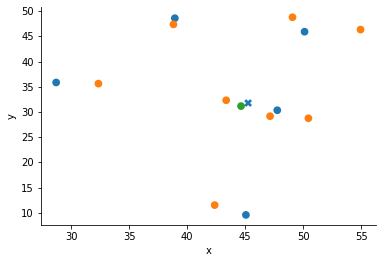

In [ ]:
sns.scatterplot(x='x',y='y',data=one_frame, hue='team', style='closest_to_fb', s=60, edgecolor='none')
plt.legend([]).set_visible(False)
sns.despine()
plt.show()

In [ ]:
off_pos = ['QB', 'WR', 'RB', 'FB', 'TE','HB']

In [ ]:
idx_intended_receiver = one_play.loc[(one_play['event']=='pass_arrived') &
                                     (one_play['position'].isin(off_pos)),
                                     'fb_distance'].idxmin()

id_intended_receiver = one_play.loc[idx_intended_receiver, 'nflId']
one_play['intended_receiver'] = 0
one_play.loc[one_play['nflId']==id_intended_receiver,'intended_receiver'] = 1
one_play = one_play.merge(one_play.loc[one_play['intended_receiver']==1, ['frameId', 'x', 'y']], on='frameId', suffixes=('', '_intended_receiver'))


In [ ]:
one_play.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,x_football,y_football,x_fb_diff,y_fb_diff,fb_distance,closest_to_fb,intended_receiver,x_intended_receiver,y_intended_receiver
0,2018-09-10T03:11:31.599Z,33.82,23.05,0.00,0.00,0.00,79.98,244.08,None,497236.0,Jimmy Graham,80.0,TE,1,home,2018090912,3564,right,CROSS,34.69,29.77,-0.87,-6.72,6.776083,0,0,32.78,19.21
1,2018-09-10T03:11:31.599Z,35.71,44.29,0.27,0.08,0.03,265.03,235.01,None,2495108.0,Prince Amukamara,20.0,CB,1,away,2018090912,3564,right,NaN,34.69,29.77,1.02,14.52,14.555782,0,0,32.78,19.21
2,2018-09-10T03:11:31.599Z,32.78,19.21,0.00,0.00,0.00,49.33,182.31,None,2495448.0,Randall Cobb,18.0,WR,1,home,2018090912,3564,right,IN,34.69,29.77,-1.91,-10.56,10.731342,0,1,32.78,19.21
3,2018-09-10T03:11:31.599Z,29.66,29.79,0.00,0.00,0.00,104.44,92.47,None,2506363.0,Aaron Rodgers,12.0,QB,1,home,2018090912,3564,right,NaN,34.69,29.77,-5.03,0.02,5.030040,0,0,32.78,19.21
4,2018-09-10T03:11:31.599Z,36.88,32.58,2.20,0.78,0.22,223.23,274.52,None,2532961.0,Danny Trevathan,59.0,ILB,1,away,2018090912,3564,right,NaN,34.69,29.77,2.19,2.81,3.562611,0,0,32.78,19.21


In [ ]:
# subtract receiver position from each row to get almost-distance
one_play.loc[:, ['x_receiver_diff', 'y_receiver_diff']] = (one_play
                                               .loc[:, ['x', 'y']]
                                               .sub(one_play
                                                    .loc[:, ['x_intended_receiver',
                                                             'y_intended_receiver']]
                                                    .values)
                                               .rename(columns={'x':'x_receiver_diff',
                                                                'y':'y_receiver_diff'}))

# calculate distance of a player from the intended receiver
one_play['receiver_distance'] = pd.Series(np.sqrt((one_play['x_receiver_diff'].values**2) +
                                            (one_play['y_receiver_diff'].values**2)),
                                    index=one_play.index)

# use some fancy pandas to get the indicies of players closest to the intended receiver
idx = one_play.loc[(one_play['team']!='football') & (one_play['nflId']!=id_intended_receiver), ['frameId', 'receiver_distance']].groupby('frameId', as_index=False).idxmin()['receiver_distance']
one_play['closest_to_receiver'] = 0
one_play.loc[idx, 'closest_to_receiver'] = 1

In [ ]:
one_play.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,x_football,y_football,x_fb_diff,y_fb_diff,fb_distance,closest_to_fb,intended_receiver,x_intended_receiver,y_intended_receiver,x_receiver_diff,y_receiver_diff,receiver_distance,closest_to_receiver
0,2018-09-10T03:11:31.599Z,33.82,23.05,0.00,0.00,0.00,79.98,244.08,None,497236.0,Jimmy Graham,80.0,TE,1,home,2018090912,3564,right,CROSS,34.69,29.77,-0.87,-6.72,6.776083,0,0,32.78,19.21,1.04,3.84,3.978341,1
1,2018-09-10T03:11:31.599Z,35.71,44.29,0.27,0.08,0.03,265.03,235.01,None,2495108.0,Prince Amukamara,20.0,CB,1,away,2018090912,3564,right,NaN,34.69,29.77,1.02,14.52,14.555782,0,0,32.78,19.21,2.93,25.08,25.250570,0
2,2018-09-10T03:11:31.599Z,32.78,19.21,0.00,0.00,0.00,49.33,182.31,None,2495448.0,Randall Cobb,18.0,WR,1,home,2018090912,3564,right,IN,34.69,29.77,-1.91,-10.56,10.731342,0,1,32.78,19.21,0.00,0.00,0.000000,0
3,2018-09-10T03:11:31.599Z,29.66,29.79,0.00,0.00,0.00,104.44,92.47,None,2506363.0,Aaron Rodgers,12.0,QB,1,home,2018090912,3564,right,NaN,34.69,29.77,-5.03,0.02,5.030040,0,0,32.78,19.21,-3.12,10.58,11.030449,0
4,2018-09-10T03:11:31.599Z,36.88,32.58,2.20,0.78,0.22,223.23,274.52,None,2532961.0,Danny Trevathan,59.0,ILB,1,away,2018090912,3564,right,NaN,34.69,29.77,2.19,2.81,3.562611,0,0,32.78,19.21,4.10,13.37,13.984524,0


In [ ]:
idx_nearest_defender = one_play.loc[(one_play['event']=='pass_arrived') &
                                     (~one_play['position'].isin(off_pos)) &
                                     (one_play['team']!='football'),
                                     'receiver_distance'].idxmin()

id_nearest_defender = one_play.loc[idx_nearest_defender, 'nflId']
one_play['nearest_defender'] = 0
one_play.loc[one_play['nflId']==id_nearest_defender,'nearest_defender'] = 1

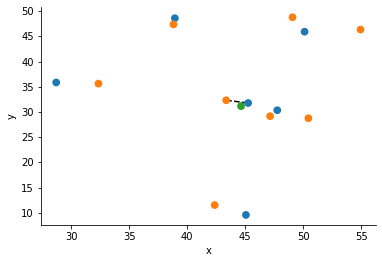

In [ ]:
# we can use this as a way to get intended receiver, since that doesn't come in that dataset
one_frame = one_play.loc[one_play['event']=='pass_arrived']
sns.scatterplot(x='x',y='y',data=one_frame, hue='team', s=60, edgecolor='none', zorder=4)
sns.lineplot(x='x',y='y',data=one_frame.loc[(one_frame['intended_receiver']==1) | (one_frame['nearest_defender']==1)], color='k', ls='--', zorder=3)
plt.legend([]).set_visible(False)
sns.despine()
plt.show()

In [ ]:
def get_play_by_frame(fid, ax):
  ax.cla()
  one_frame = one_play.loc[one_play['frameId']==fid]
  fig1 = sns.scatterplot(x='x',y='y',data=one_frame, hue='team', ax=ax, zorder=4)
  fig1 = sns.lineplot(x='x',y='y',data=one_frame.loc[(one_frame['intended_receiver']==1) | (one_frame['nearest_defender']==1)], color='k', ls='--', zorder=3, ax=ax)
  fig1.axvline(los, c='k', ls=':')
  fig1.axvline(0, c='k', ls='-')
  fig1.axvline(100, c='k', ls='-')
  fig1.legend([]).set_visible(False)
  sns.despine(left=True)
  fig1.set_ylabel('')
  fig1.set_yticks([])
  fig1.set_xlim(-10,110)
  fig1.set_ylim(0,53.3)


In [ ]:
fig = plt.figure()
ax = fig.gca()
ani = animation.FuncAnimation(fig, get_play_by_frame,
                              frames=one_play['frameId'].sort_values().unique().shape[0],
                              interval=100, repeat=True, fargs=(ax,))

plt.close()
ani.save('play.gif', writer='imagemagick', fps=10)
ani

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np

In [ ]:
np.arange(10,101,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [ ]:

fig = plt.figure()
ax = fig.gca()
ani = animation.FuncAnimation(fig, get_play_by_frame,
                              frames=one_play['frameId'].sort_values().unique().shape[0],
                              interval=100, repeat=True, fargs=(ax,))

plt.close()
ani.save('play.gif', writer='imagemagick', fps=10)
ani

In [ ]:
pass_events = ['ball_snap', 'pass_forward', 'pass_arrived']
for idx, e in enumerate(pass_events):
  _nearest_def = one_play.loc[one_play['nearest_defender']==1]
  if idx==0:
    nearest_defender = _nearest_def.loc[_nearest_def['event']==e, ['fb_distance', 'receiver_distance']].rename(columns={'fb_distance':f"fb_distance_{e}", 'receiver_distance':f"receiver_distance_{e}"}).reset_index(drop=True)
  else:
    _nearest_defender = _nearest_def.loc[_nearest_def['event']==e, ['fb_distance', 'receiver_distance']].rename(columns={'fb_distance':f"fb_distance_{e}", 'receiver_distance':f"receiver_distance_{e}"}).reset_index(drop=True)
    nearest_defender = nearest_defender.merge(_nearest_defender, left_index=True, right_index=True)

nearest_defender['nflId'] = _nearest_def['nflId'].unique()[0]
nearest_defender['displayName'] = _nearest_def['displayName'].unique()[0]
nearest_defender['gameId'] = _nearest_def['gameId'].unique()[0]
nearest_defender['playId'] = _nearest_def['playId'].unique()[0]
nearest_defender['success'] = int(bool(np.sum([1 if ('pass_outcome_caught' in x) | ('pass_outcome_touchdown' in x) else 0 for x in one_play['event'].unique()])))

# Let's make the loop and do the damn thing  

the code upstairs is so f'ing messy, i really don't know how long the refactor is going to take. i have enough whiskey and beer to last me the entire refactor session. so lfgggggggggggggggggg

In [ ]:
try:
  df_nearest_defender = pd.read_csv(f"""{project_dir}/processed_data/df_nearest_defender.csv""", index_col=0)
except:
  # this takes an HOUR to run, strong recommend finding a save file
  off_pos = ['QB', 'WR', 'RB', 'FB', 'TE','HB']
  pass_events = ['ball_snap', 'pass_forward', 'pass_arrived']
  df_nearest_defender = pd.DataFrame()
  for week_fn in tqdm(weeks_fns, leave=True):
    one_week = pd.read_csv(week_fn)
    print(f"iterations: {one_week.loc[:, ['gameId', 'playId']].drop_duplicates().shape[0]}")
    for idx, row in tqdm(one_week.loc[:, ['gameId', 'playId']].drop_duplicates().iterrows(), leave=False):
      # grab one play
      one_play = one_week.merge(row.to_frame().T)

      # make some columns that are specific to where the football is
      # you can exclude them from the rows as well if you want
      one_play = one_play.merge(one_play.loc[(one_play['team']=='football'), ['frameId', 'x', 'y']], on='frameId', suffixes=('', '_football'))

      # check for pass attempt
      if not bool(np.sum([1 if x in ['pass_forward', 'pass_arrived', 'pass_outcome_incomplete'] else 0 for x in one_play['event'].unique()])):
        continue
      elif np.sum([1 if x in pass_events else 0 for x in one_play['event'].unique()]) < 3:
        continue
      elif one_play['position'].dropna().isin(off_pos).sum() < 1:
        continue
      elif (~one_play['position'].dropna().isin(off_pos)).sum() < 1:
        continue

      # subtract football position from each row to get almost-distance
      one_play.loc[:, ['x_fb_diff', 'y_fb_diff']] = (one_play
                                                    .loc[:, ['x', 'y']]
                                                    .sub(one_play
                                                          .loc[:, ['x_football',
                                                                  'y_football']]
                                                          .values)
                                                    .rename(columns={'x':'x_fb_diff',
                                                                      'y':'y_fb_diff'}))

      # calculate distance of a player from the football
      one_play['fb_distance'] = pd.Series(np.sqrt((one_play['x_fb_diff'].values**2) +
                                                  (one_play['y_fb_diff'].values**2)),
                                          index=one_play.index)

      # use some fancy pandas to get the indicies of players closest to the football
      idx = one_play.loc[(one_play['team']!='football'), ['frameId', 'fb_distance']].groupby('frameId', as_index=False).idxmin()['fb_distance']
      one_play['closest_to_fb'] = 0
      one_play.loc[idx, 'closest_to_fb'] = 1

      # identify the intended receiver based on where the ball is when the pass arrives
      idx_intended_receiver = one_play.loc[(one_play['event'].isin(['pass_arrived',
                                                                    'pass_forward',
                                                                    'pass_outcome_caught',
                                                                    'pass_outcome_incomplete',
                                                                    'pass_outcome_interception'])) &
                                          (one_play['position'].isin(off_pos)),
                                          'fb_distance'].idxmin()

      id_intended_receiver = one_play.loc[idx_intended_receiver, 'nflId']
      one_play['intended_receiver'] = 0
      one_play.loc[one_play['nflId']==id_intended_receiver,'intended_receiver'] = 1
      one_play = one_play.merge(one_play.loc[one_play['intended_receiver']==1, ['frameId', 'x', 'y']], on='frameId', suffixes=('', '_intended_receiver'))

      # subtract receiver position from each row to get almost-distance
      one_play.loc[:, ['x_receiver_diff', 'y_receiver_diff']] = (one_play
                                                    .loc[:, ['x', 'y']]
                                                    .sub(one_play
                                                          .loc[:, ['x_intended_receiver',
                                                                  'y_intended_receiver']]
                                                          .values)
                                                    .rename(columns={'x':'x_receiver_diff',
                                                                      'y':'y_receiver_diff'}))

      # calculate distance of a player from the intended receiver
      one_play['receiver_distance'] = pd.Series(np.sqrt((one_play['x_receiver_diff'].values**2) +
                                                  (one_play['y_receiver_diff'].values**2)),
                                          index=one_play.index)

      # use some fancy pandas to get the indicies of players closest to the intended receiver
      idx = one_play.loc[(one_play['team']!='football') & (one_play['nflId']!=id_intended_receiver), ['frameId', 'receiver_distance']].groupby('frameId', as_index=False).idxmin()['receiver_distance']
      one_play['closest_to_receiver'] = 0
      one_play.loc[idx, 'closest_to_receiver'] = 1

      # identify nearest defender
      idx_nearest_defender = one_play.loc[(one_play['event'].isin(['pass_arrived',
                                                                  'pass_forward',
                                                                  'pass_outcome_caught',
                                                                  'pass_outcome_incomplete',
                                                                  'pass_outcome_interception'])) &
                                          (~one_play['position'].isin(off_pos)) &
                                          (one_play['team']!='football'),
                                          'receiver_distance'].idxmin()

      id_nearest_defender = one_play.loc[idx_nearest_defender, 'nflId']
      one_play['nearest_defender'] = 0
      one_play.loc[one_play['nflId']==id_nearest_defender,'nearest_defender'] = 1

      # isolate nearest defender to receiver at pass arrival
      # pivot out specific events to a wide format; one row == one defender
      for idx, e in enumerate(pass_events):
        _nearest_def = one_play.loc[one_play['nearest_defender']==1]
        if idx==0:
          nearest_defender = _nearest_def.loc[_nearest_def['event']==e, ['fb_distance', 'receiver_distance']].rename(columns={'fb_distance':f"fb_distance_{e}", 'receiver_distance':f"receiver_distance_{e}"}).reset_index(drop=True)
        else:
          _nearest_defender = _nearest_def.loc[_nearest_def['event']==e, ['fb_distance', 'receiver_distance']].rename(columns={'fb_distance':f"fb_distance_{e}", 'receiver_distance':f"receiver_distance_{e}"}).reset_index(drop=True)
          nearest_defender = nearest_defender.merge(_nearest_defender, left_index=True, right_index=True)

      nearest_defender['nflId'] = _nearest_def['nflId'].unique()[0]
      nearest_defender['displayName'] = _nearest_def['displayName'].unique()[0]
      nearest_defender['gameId'] = _nearest_def['gameId'].unique()[0]
      nearest_defender['playId'] = _nearest_def['playId'].unique()[0]
      nearest_defender['success'] = int(bool(np.sum([1 if ('pass_outcome_caught' in x) | ('pass_outcome_touchdown' in x) else 0 for x in one_play['event'].unique()])))
      df_nearest_defender = df_nearest_defender.append(nearest_defender, ignore_index=True)

  df_nearest_defender.to_csv(f"""{project_dir}/processed_data/df_nearest_defender.csv""")

In [ ]:
# really simple linear model for predicting pass success

model_feats = ['fb_distance_ball_snap', 'receiver_distance_ball_snap',
       'fb_distance_pass_forward', 'receiver_distance_pass_forward',
       'fb_distance_pass_arrived', 'receiver_distance_pass_arrived']
target = 'success'
df_pred = pd.DataFrame()
model_data = df_nearest_defender.loc[:, model_feats+[target]].dropna()
kf = KFold(10, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  logr_model = LogisticRegression()
  logr_model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
  test_data[f'{target}_pred'] = pd.DataFrame(logr_model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

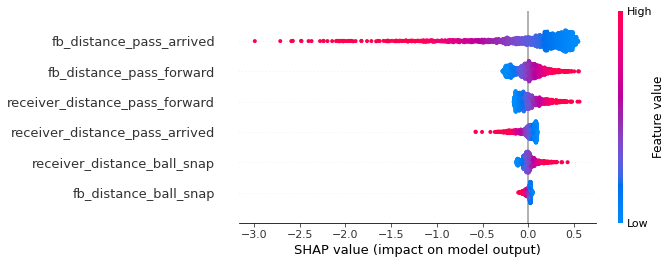

In [ ]:
# basic feature importance -- could remove ball snap info
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(logr_model, train_data.loc[:,model_feats].sample(2000))
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [ ]:
# predicted loss vs naive loss
# naive loss is simply using the mean for "success" as the predictor

my_loss = log_loss(df_pred['success'], df_pred['success_pred'])
naive_loss = log_loss(df_pred['success'], np.repeat(df_pred['success'].mean(), df_pred.shape[0]))

# predicted acc vs naive acc
my_acc = accuracy_score(df_pred['success'], df_pred['success_pred'].round(0))
naive_acc = accuracy_score(df_pred['success'], np.repeat(round(df_pred['success'].mean(),0), df_pred.shape[0]))

print(f"my loss: {my_loss}\nnaive loss (mean pred): {naive_loss}\n\nmy acc: {my_acc}\nnaive acc (mean pred): {naive_acc}")

my loss: 0.4971185343125497
naive loss (mean pred): 0.5388240931024553

my acc: 0.7897974701043755
naive acc (mean pred): 0.770373954517177


In [ ]:
# i'm calling it dpoe, the cousin of cpoe
df_nearest_defender['dpoe'] = df_pred['success_pred'].sub(df_pred['success'])

In [ ]:
df_dpoe = df_nearest_defender.loc[:, ['nflId', 'displayName', 'dpoe']].groupby(['nflId', 'displayName'], as_index=False).sum()
df_dpoe = df_dpoe.sort_values('dpoe', ascending=False)

In [ ]:
# defending passes above expected
df_dpoe.head(10)

,nflId,displayName,dpoe
97,2532966.0,Bobby Wagner,14.676662
303,2555329.0,Myles Jack,10.198206
157,2540288.0,Darius Slay,10.188696
250,2552490.0,Benardrick McKinney,9.657094
405,2558064.0,T.J. Watt,8.660395
517,2560917.0,Fred Warner,8.436634
216,2550842.0,Adrian Phillips,8.123047
300,2555310.0,Jaylon Smith,7.736867
104,2533056.0,Luke Kuechly,7.260092
292,2555256.0,Jordan Jenkins,7.149542


In [ ]:
# defending passes below expected
df_dpoe.tail(10)

,nflId,displayName,dpoe
384,2557927.0,Desmond King,-5.210499
321,2555530.0,Vonn Bell,-5.237156
253,2552592.0,Kwon Alexander,-5.427704
333,2556119.0,Elandon Roberts,-5.652325
399,2558009.0,Budda Baker,-5.654346
540,2561015.0,Lorenzo Carter,-5.691570
111,2533534.0,Olivier Vernon,-5.845544
182,2543597.0,Avery Williamson,-5.875384
56,2506268.0,Lorenzo Alexander,-6.372408
9,79848.0,Malcolm Jenkins,-6.981384


I think this is a pretty simple way to compute defending passes in a way that is utilizing the player tracking data and creating some novel insight beyond what we already knew. We already knew that if a defender was close to the receiver and also in the way of the path of the ball, the success of a completed pass would not be as likely relative to if a defender was not near an intended receiver (or in the throwing path). That is to say, we already knew good defenders play the intended receivers closely and read the eyes of the passer closely.  

What we did not know what at what point did the defender begin to decrease the success rate of a pass? Was it the distance to the intended receiver before snap? During the throw? As the ball arrived? Of those three events, the QB throw and distance of defender from receiver + distance from ball and defender were the most important features in this model. It's early and somewhat of a large claim to say a defender is most impactful when the ball is still in the hands of the QB, but feature importance seems to indicate this is a differentiator between a completed vs an incompleted pass.  

Furthermore, the model (which is based on the average NFL pass defender) can be used to create an "over-expected" type model simply by subtracting whether or not the pass was successful from the prediction. Flipping the sign of this will give credit to defenders in terms of passes defended vs taxing defenders when passes are completed. We can call this statistic "defended passes over expected" (DPOE) which would be a simple and novel cousin to the already-established completed pass over expected (CPOE).

To clean this up, I'd probably include yard line of the play, to get a proxy for pass success (since success can vary depending on field position).

Might be more accurate to use fastR's intended receiver feature vs back calculating. Also, speed of nearest defender might be a good feature. And perhaps orientation pointed towards the receiver (like where 0 is the receiver and orientation is adjusted to whether the nearest defender is pointed towards the receiver or not).

Obviously, other modeling types could help a lot. Unsure if these features are really linear -- some could exhibit nonlinear behavior. However, for now, this attempt does do better than simply guessing the mean.

-nw 10/18/2020

In [ ]:
df_nearest_defender.sort_values('fb_distance_pass_arrived')

,fb_distance_ball_snap,receiver_distance_ball_snap,fb_distance_pass_forward,receiver_distance_pass_forward,fb_distance_pass_arrived,receiver_distance_pass_arrived,nflId,displayName,gameId,playId,success,dpoe,height,weight,birthDate,collegeName,position
4754,6.447030,8.388236,18.944184,1.363562,0.042426,1.869545,2555329.0,Myles Jack,2018100705,2749,1,-0.132700,73,244,1995-09-03,UCLA,OLB
1366,12.571619,2.091220,20.706117,1.012373,0.050000,0.698570,2555277.0,Eli Apple,2018120907,170,0,0.859400,73,203,1995-08-09,Ohio State,CB
5484,4.060788,9.586167,21.516926,1.698499,0.067082,0.874757,2540143.0,Alec Ogletree,2018092303,2913,0,0.879318,75,250,1991-09-25,Georgia,LB
7479,18.429360,3.846414,27.916196,1.241692,0.082462,1.060000,2495108.0,Prince Amukamara,2018111100,3745,1,-0.123082,72,204,1989-06-06,Nebraska,CB
11325,13.647425,1.938298,29.309011,1.930622,0.100499,0.762168,2558259.0,Shaquill Griffin,2018111500,3367,1,-0.118284,72,198,1995-07-20,Central Florida,CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,2.960152,6.199161,2.625738,2.695199,55.252012,7.911744,2560718.0,Rashaan Evans,2018120211,344,0,0.093675,74,234,1995-11-08,Alabama,LB
12128,5.632566,6.365666,20.276639,20.584484,55.271349,12.211048,2555307.0,Devante Bond,2018123010,3365,1,-0.819917,73,236,1993-07-03,Oklahoma,OLB
3243,6.208462,7.971775,2.086936,2.265259,55.757408,8.036579,2561015.0,Lorenzo Carter,2018111805,4118,0,0.094212,77,250,1995-12-10,Georgia,OLB
9649,5.553089,8.032994,5.143705,5.593219,57.485282,4.921839,2556641.0,Romeo Okwara,2018121602,1988,0,0.098953,76,263,1995-06-17,Notre Dame,DE


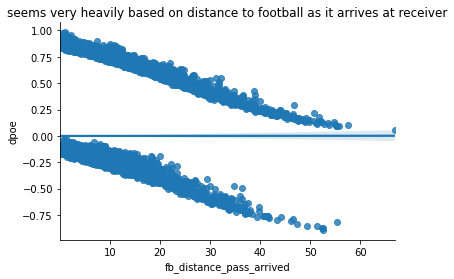

In [ ]:
x='fb_distance_pass_arrived'
y='dpoe'
df_plt = df_nearest_defender.loc[:, [x,y]]
sns.regplot(x=x,y=y,data=df_plt)
plt.title('seems very heavily based on distance to football as it arrives at receiver')
sns.despine()
plt.show()

I suppose it's not that crazy to think the closer a defender is to the ball, the less likely it is to catch the ball. Thus, if the probability of the catch is low (say, 10%) and the receiver catches it, then the defender should incur a -0.9 DPOE

In [ ]:
df_nearest_defender = df_nearest_defender.merge(df_players)
df_nearest_defender.shape

(14372, 17)

In [ ]:
df_nearest_defender.sort_values('fb_distance_pass_arrived')

,fb_distance_ball_snap,receiver_distance_ball_snap,fb_distance_pass_forward,receiver_distance_pass_forward,fb_distance_pass_arrived,receiver_distance_pass_arrived,nflId,displayName,gameId,playId,success,dpoe,height,weight,birthDate,collegeName,position
4754,6.447030,8.388236,18.944184,1.363562,0.042426,1.869545,2555329.0,Myles Jack,2018100705,2749,1,-0.132700,73,244,1995-09-03,UCLA,OLB
1366,12.571619,2.091220,20.706117,1.012373,0.050000,0.698570,2555277.0,Eli Apple,2018120907,170,0,0.859400,73,203,1995-08-09,Ohio State,CB
5484,4.060788,9.586167,21.516926,1.698499,0.067082,0.874757,2540143.0,Alec Ogletree,2018092303,2913,0,0.879318,75,250,1991-09-25,Georgia,LB
7479,18.429360,3.846414,27.916196,1.241692,0.082462,1.060000,2495108.0,Prince Amukamara,2018111100,3745,1,-0.123082,72,204,1989-06-06,Nebraska,CB
11325,13.647425,1.938298,29.309011,1.930622,0.100499,0.762168,2558259.0,Shaquill Griffin,2018111500,3367,1,-0.118284,72,198,1995-07-20,Central Florida,CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,2.960152,6.199161,2.625738,2.695199,55.252012,7.911744,2560718.0,Rashaan Evans,2018120211,344,0,0.093675,74,234,1995-11-08,Alabama,LB
12128,5.632566,6.365666,20.276639,20.584484,55.271349,12.211048,2555307.0,Devante Bond,2018123010,3365,1,-0.819917,73,236,1993-07-03,Oklahoma,OLB
3243,6.208462,7.971775,2.086936,2.265259,55.757408,8.036579,2561015.0,Lorenzo Carter,2018111805,4118,0,0.094212,77,250,1995-12-10,Georgia,OLB
9649,5.553089,8.032994,5.143705,5.593219,57.485282,4.921839,2556641.0,Romeo Okwara,2018121602,1988,0,0.098953,76,263,1995-06-17,Notre Dame,DE


In [ ]:
df_nearest_defender.loc[:, ['collegeName', 'dpoe']].groupby('collegeName', as_index=False).sum().sort_values('dpoe', ascending=False).head(10)

,collegeName,dpoe
137,Utah State,16.955330
1,Alabama,16.435997
68,Mississippi State,15.926793
134,UCLA,15.027164
118,Southern California,14.972710
10,Boston College,11.447655
91,Notre Dame,11.144002
154,Wisconsin,8.881904
141,Virginia Tech,8.555300
128,Texas,8.296532


In [ ]:
df_nearest_defender.loc[:, ['collegeName', 'dpoe']].groupby('collegeName', as_index=False).sum().sort_values('dpoe', ascending=False).tail(10)

,collegeName,dpoe
18,Chattanooga,-6.031968
12,California,-6.800918
6,Auburn,-6.981357
30,Florida,-7.287991
44,Iowa,-7.501773
60,Miami,-7.581899
66,Minnesota,-8.102629
47,Kansas,-9.599420
32,Florida State,-11.465150
144,Washington,-12.538671


count    563.000000
mean      25.527531
std       23.310236
min        1.000000
25%        6.000000
50%       20.000000
75%       40.000000
max      133.000000
Name: count, dtype: float64

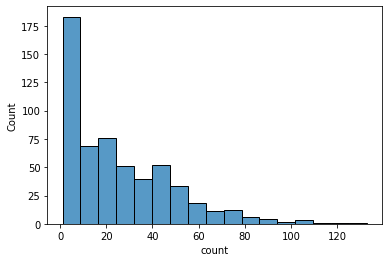

In [ ]:
df_count = df_nearest_defender.loc[:, ['position', 'nflId','displayName', 'dpoe']].groupby(['position', 'nflId','displayName'], as_index=False).count().rename(columns={'dpoe':'count'})
sns.histplot(df_count['count'])
df_count['count'].describe()
# could use median overall as a threshold. thinking mean of secondary might be better?

In [ ]:
pos = ['CB', 'DB','SS', 'FS', 'S']
# pos = ['OLB','ILB', 'MLB', 'LB']
# pos = ['DE','DT', 'NT']
df_agg = df_nearest_defender.loc[:, ['position', 'nflId','displayName', 'dpoe']].groupby(['position', 'nflId','displayName'], as_index=False).sum().sort_values('dpoe', ascending=False)
df_agg = df_agg.merge(df_count)
df_agg['dpoe_per_play'] = df_agg['dpoe'].div(df_agg['count'])
threshold = df_agg.loc[df_agg['position'].isin(['CB', 'DB','SS', 'FS', 'S']), 'count'].median()
df_agg = df_agg.loc[df_agg['count']>threshold]
df_agg = df_agg.loc[df_agg['position'].isin(pos)]
df_agg['rank'] = np.arange(1, df_agg.shape[0]+1)
_blank = pd.DataFrame(index=[0], columns=['rank', 'position', 'displayName', 'dpoe', 'count', 'dpoe_per_play']).fillna(' ')
d1 = df_agg.loc[:, ['rank', 'position', 'displayName', 'dpoe', 'count', 'dpoe_per_play']].head(10)
d2 = df_agg.loc[:, ['rank', 'position', 'displayName', 'dpoe', 'count', 'dpoe_per_play']].tail(10)
d1.append(_blank).append(d2)

,rank,position,displayName,dpoe,count,dpoe_per_play
2,1,CB,Darius Slay,10.1887,53,0.19224
6,2,SS,Adrian Phillips,8.12305,42,0.193406
12,3,S,Minkah Fitzpatrick,5.83466,42,0.138921
13,4,CB,Kendall Fuller,5.70173,77,0.0740484
16,5,CB,James Bradberry,5.30381,59,0.089895
18,6,CB,Orlando Scandrick,5.21824,50,0.104365
20,7,CB,Stephon Gilmore,5.18614,40,0.129654
24,8,CB,Marlon Humphrey,4.55144,34,0.133866
25,9,FS,Tre Boston,4.37788,34,0.128761
27,10,FS,Adrian Amos,4.15773,36,0.115492


In [ ]:
df_agg['dpoe'].describe()

count    563.000000
mean      -0.010900
std        2.405725
min       -6.981384
25%       -1.083629
50%       -0.168888
75%        0.886004
max       14.676662
Name: dpoe, dtype: float64

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


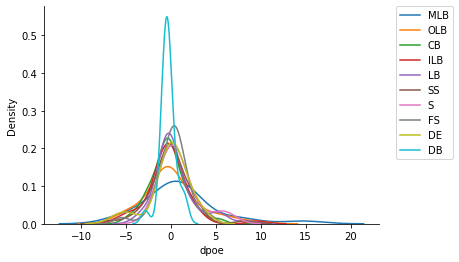

In [ ]:
for pos in df_agg['position'].unique():
  sns.kdeplot(df_agg.loc[df_agg['position']==pos, 'dpoe'], label=pos)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()